# Introduction to the Usage of My Code

Welcome to this Jupyter Notebook, which serves as a showcase for the usage of my code. This notebook is designed to assist you in creating your own code for further analyzing registered images.

## Objectives

In this notebook, we will cover the following topics:

1. **Loading the Micasense Image**: Learn how to load the Micasense image.
2. **Registering Images**: Explore two methods for image registration.
3. **Saving Images**: Understand how to save the registered images.
4. **Loading Registered Images**: Learn how to load the registered images.
5. **RegisteredMicasense Class**: Discover how to handle the `RegisteredMicasense` class.


## Loading the Micasense Image

In this section, we will learn how to correctly load Micasense images using the classes provided in the Micasense repository: [Micasense Image Processing](https://github.com/micasense/imageprocessing/tree/master), to then use the registration code.

In [6]:
#Step 1: Import Required Classes
from registration.registration_with_depth_matching import set_intrinsic
from src import utils
from micasense import capture
from pathlib import Path

# Step 2: Define Paths
micasense_calib_path = "calib/micasense_calib.yaml"  # Path to the calibration file
micasense_path = Path("/media/david/T71/multispektral/20240416_esteburg/0006SET/000")  # Path to the images
micasense_image_number = "0042"  # Specify the image number to load

# Step 3: Load the Images
image_names = sorted(list(micasense_path.glob(f'IMG_{micasense_image_number}_*.tif')))  # Collect image paths
image_names = [x.as_posix() for x in image_names]  # Convert to POSIX paths

# Create a Capture object from the file list
thecapture = capture.Capture.from_filelist(image_names)  # Load the images into a Capture object

# Read the Micasense calibration
micasense_calib = utils.read_micasense_calib(micasense_calib_path)  # Load calibration data

# Set the intrinsic parameters
set_intrinsic(thecapture, micasense_calib)  # Apply the calibration to the capture


## Registering Images

In this section, we will explore how to use the two implemented methods for registering Micasense images: **Feature Matching** and **Depth Matching (3D Transformation)**. Each method has its own strengths and is suited for different scenarios depending on the nature of the images and the required accuracy.

### Method 1: Feature Matching

Feature matching involves identifying key points in the images and matching them to align the images.



In [ ]:
# Step 1: Import Required Functions
from registration.registration_with_feature_matching import register

# Step 2: Specify Parameters
version = "upsampled"  # Choose between "stack" or "upsampled"
save_warp_matrices = True  # Set to True to save the warp matrices

# Step 3: Register the Images
file_names = utils.extract_all_image_names(image_names)  # Extract all image names from the capture
registered_images = register(thecapture, version, save_warp_matrices, file_names)  # Register images


### Method 2: Depth Matching (3D Transformation)

Depth matching uses depth information along with intrinsic and extrinsic parameters between two cameras to align images

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from registration.registration_with_depth_matching import register

# Define paths
depth_path = "/media/david/T71/SAMSON1_depth_old/SAMSON1_depth"
samson1_path = "calib/SAMSON1_SAMSON2_stereo.yaml"

# Determine the depth map number based on the image name
depth_map_number = int(utils.get_number_from_image_name(image_names[0])) + 1

# Define Basler camera size
basler_size = (5328, 4608)

# Find and load the corresponding depth map
file_to_depth_map = utils.find_depth_map_file(depth_path, depth_map_number)
depth_map = np.load(file_to_depth_map)

# Resize the depth map to match the camera size
depth_map_resized = cv2.resize(depth_map, basler_size, interpolation=cv2.INTER_LINEAR)

# Read camera calibration parameters
cal_samson_1 = utils.read_basler_calib(samson1_path)
K_L, D_L, P_L, _ = cal_samson_1

# Extract all image names from the capture
file_names = utils.extract_all_image_names(image_names)

# Perform depth matching registration
registered_images = register(thecapture, depth_map_resized, micasense_calib, P_L, file_names)

## Saving Images
After successfully registering the images, it could be usefully to save the registered bands for further analysis. In this section, we will demonstrate how to save each registered image (band) as its own TIFF file.
We will use the `save_images` method provided by the registered bands object to save each registered band as a separate TIFF file.

In [ ]:
save_to = "output/depth_matching"  # Replace with your desired path

# Save each registered image (band) as its own TIFF
registered_images.save_images(save_to)

## Loading Registered Images
Once the images have been saved after registration, you can easily load them for further processing or analysis. In this section, we will demonstrate how to load registered images using the implemented `RegisteredMicasense` class.


In [ ]:
# Import the RegisteredMicasense class
from micasense.registered_micasense import RegisteredMicasense
from pathlib import Path

# Specify the path to the registered images
path_to_registered_images = Path(save_to)  # Ensure save_to is defined and points to the correct directory
image_number = "0042"  # Specify the image number you wish to load

# Load image names matching the given image number
image_names = sorted(path_to_registered_images.glob(f'IMG_{image_number}_*.tif'))
image_names = [x.as_posix() for x in image_names]

# Extract file names
file_names = utils.extract_all_image_names(image_names)

# Create a RegisteredMicasense object
registered_images = RegisteredMicasense(image_names, file_names)

## RegisteredMicasense Class
The `RegisteredMicasense` class is implemented to handle registered Micasense RedEdge-P images. This class provides methods for accessing individual image bands and stacks of images, facilitating easier analysis and manipulation of multispectral data.
### `get_image`
The `get_image` method allows you to retrieve individual image bands either by their index or by their name.

In [ ]:
# Retrieve the blue band by index
blue_band_by_index = registered_images.get_image(0)  # Blue band

# Retrieve the blue band by name
blue_band_by_name = registered_images.get_image("blue")  # Blue band

### `get_stack`
The get_stack method retrieves multiple bands as a single stack. You can also crop the stack or select specific bands to create a stack.

In [ ]:
# Retrieve all 6 bands as a stack
stack = registered_images.get_stack()

# Retrieve all 6 bands as a cropped stack
stack_crop = registered_images.get_stack(cropping=True)

# Retrieve the RGB stack by index
stack_rgb_by_index = registered_images.get_stack(images=[2, 1, 0])  # RGB stack

# Retrieve the RGB stack by name
stack_rgb_by_name = registered_images.get_stack(images=["red", "green", "blue"])

### `get_rgb_normalized`
The `get_rgb_normalized` method is used to retrieve the normalized RGB representation of the registered Micasense images. This method can return the RGB image in various forms, including the option to crop and enhance the image.


In [ ]:
# Retrieve the RGB image
rgb = registered_images.get_rgb_normalized()

# Retrieve the RGB image with cropping
rgb_crop = registered_images.get_rgb_normalized(crop=True)

# Retrieve the cropped and enhanced RGB image
rgb_crop_enhanced = registered_images.get_rgb_normalized(crop=True, enhanced=True)

### `get_cir_normalized`
The `get_cir_normalized` method retrieves the normalized Continuous Infrared (CIR) representation of the registered Micasense images. This method can also return a cropped version of the CIR image if needed.


In [ ]:
# Retrieve the normalized CIR image
cir = registered_images.get_cir_normalized()

# Retrieve the cropped CIR image
cir_crop = registered_images.get_cir_normalized(cropping=True)

### `get_ndvi`
The `get_ndvi` method calculates and retrieves the Normalized Difference Vegetation Index (NDVI) from the registered Micasense images. NDVI is a widely used vegetation index that helps assess plant health and cover.

In [ ]:
# Calculate and retrieve the NDVI image
ndvi = registered_images.get_ndvi()

# Calculate and retrieve the cropped NDVI image
ndvi_crop = registered_images.get_ndvi(cropping=True)

### `get_ndre`
The `get_ndre` method calculates and retrieves the Normalized Difference Red Edge (NDRE) index from the registered Micasense images. NDRE is a useful vegetation index for assessing plant health, particularly in detecting nutrient stress in crops.

In [ ]:
# Calculate and retrieve the NDRE image
ndre = registered_images.get_ndre()

# Calculate and retrieve the cropped NDRE image
ndre_crop = registered_images.get_ndre(cropping=True)

## `Visualize the images`
In this section, we will visualize the different processed images, including RGB, Color Infrared (CIR), NDVI, and NDRE images. Using Matplotlib, we can create a grid of subplots to display these images side by side for easy comparison.

NameError: name 'rgb' is not defined

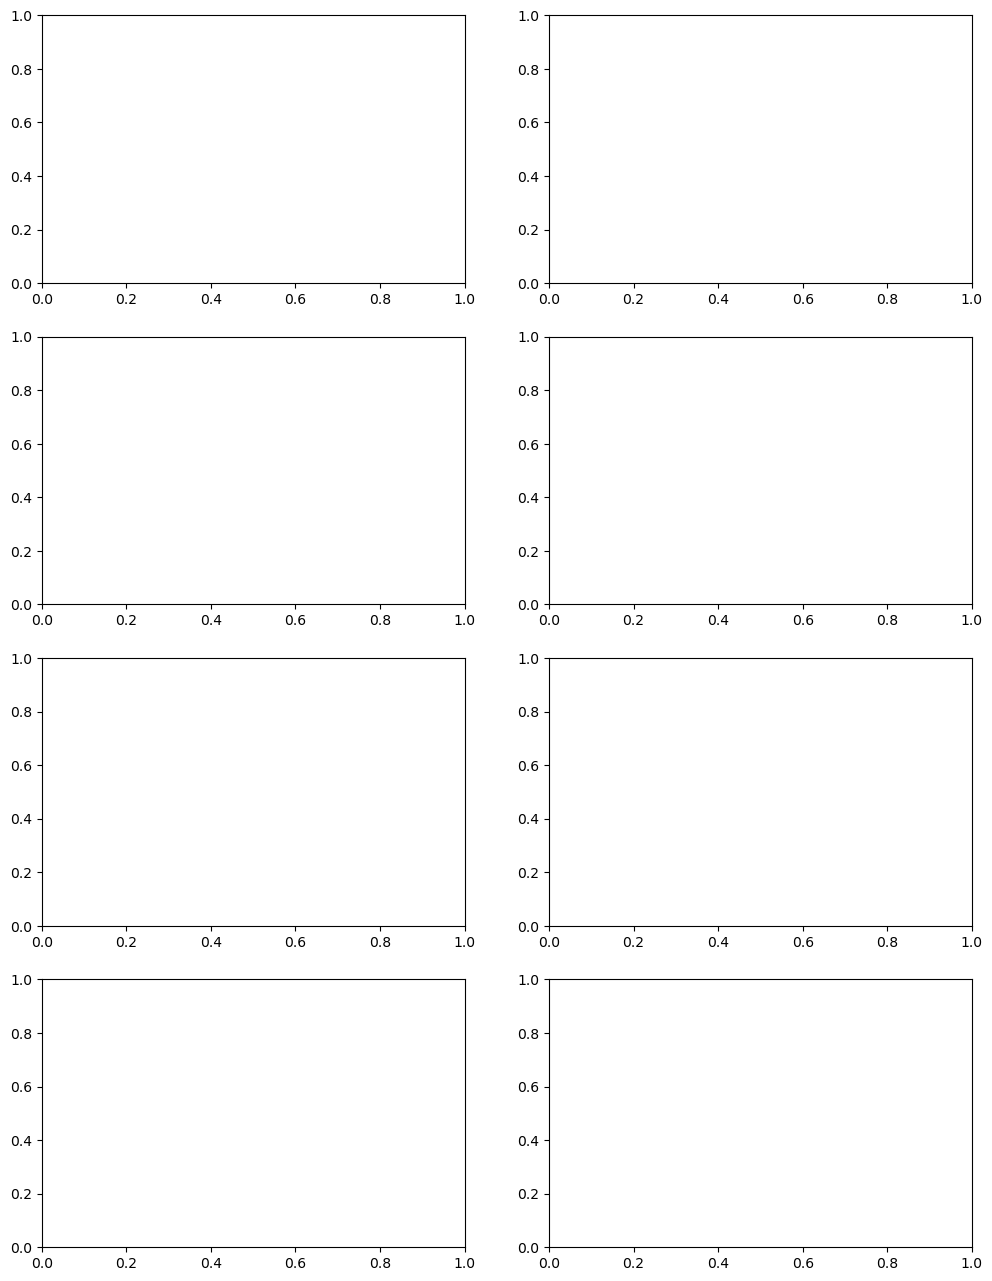

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Display RGB images
axs[0, 0].imshow(rgb)
axs[0, 0].set_title('RGB Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(rgb_crop)
axs[0, 1].set_title('Cropped RGB Image')
axs[0, 1].axis('off')

# Display CIR images
axs[1, 0].imshow(cir)
axs[1, 0].set_title('Color Infrared (CIR) Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(cir_crop)
axs[1, 1].set_title('Cropped CIR Image')
axs[1, 1].axis('off')

    # Display NDVI images
axs[2, 0].imshow(ndvi, cmap='hot')
axs[2, 0].set_title('NDVI Image')
axs[2, 0].axis('off')

axs[2, 1].imshow(ndvi_crop, cmap='hot')
axs[2, 1].set_title('Cropped NDVI Image')
axs[2, 1].axis('off')

    # Display NDRE images
axs[3, 0].imshow(ndre, cmap='hot')
axs[3, 0].set_title('NDRE Image')
axs[3, 0].axis('off')

axs[3, 1].imshow(ndre_crop, cmap='hot')
axs[3, 1].set_title('Cropped NDRE Image')
axs[3, 1].axis('off')

plt.tight_layout()
plt.show()
